Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, url_path, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + url_path, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('../data/text8.zip', 'text8.zip', 31344016)

Found and verified ../data/text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))
print(words[:10])

Data size 17005207
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  # Why is UNK in a list but every other word in a tuple?
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('dictionary[the]:', dictionary['the'])
print('dictionary[of]:', dictionary['of'])
print('dictionary[and]:', dictionary['and'])
print('reverse_dictionary[0]', reverse_dictionary[0])
print('reverse_dictionary[1]', reverse_dictionary[1])
print('reverse_dictionary[2]', reverse_dictionary[2])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
dictionary[the]: 1
dictionary[of]: 2
dictionary[and]: 3
reverse_dictionary[0] UNK
reverse_dictionary[1] the
reverse_dictionary[2] of


Function to generate a training batch for the skip-gram model.

In [13]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      # If num_skips==(skip_window*2), then the last iteration of this 
      #     while loop, when j==(num_skips-1), has only one possible option.
      while target in targets_to_avoid:
        # Non deterministic
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      # skip_window is the index to the 'center' word.
      batch[i * num_skips + j] = buffer[skip_window]
      # target is the index to the current 'skip' word.
      labels[i * num_skips + j, 0] = buffer[target]
#     print('    before buffer append:', buffer)
    # During an append, data is kicked out from the left siged because maxlen==span.
    buffer.append(data[data_index])
#     print('        after buffer append:', buffer)    
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

# num_skips - number of words to choose from inside the window, not including the center word.
# skip_window - number of words on either side to include in the window
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)    
    print('    reverse dictionary batch:', [reverse_dictionary[bi] for bi in batch])
    print('    reverse dictionary labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    batch:', batch)
    print('    labels:', labels)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    reverse dictionary batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    reverse dictionary labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a']
    batch: [3084 3084   12   12    6    6  195  195]
    labels: [[5239]
 [  12]
 [3084]
 [   6]
 [  12]
 [ 195]
 [   2]
 [   6]]

with num_skips = 4 and skip_window = 2:
    reverse dictionary batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    reverse dictionary labels: ['a', 'originated', 'anarchism', 'term', 'term', 'originated', 'of', 'as']
    batch: [12 12 12 12  6  6  6  6]
    labels: [[   6]
 [3084]
 [5239]
 [ 195]
 [ 195]
 [3084]
 [   2]
 [  12]]


Train a skip-gram model.

In [14]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
print('valid_examples: ', valid_examples)
print('    as words: ', [reverse_dictionary[x] for x in valid_examples])
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  print('embeddings.shape', embeddings.get_shape())
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  print('softmax_weights.get_shape()', softmax_weights.get_shape())
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  print('softmax_biases.get_shape(): ', softmax_biases.get_shape())
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print('embed.shape: ', embed.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

valid_examples:  [89 64 72 36  5 59 58 86  3 49 35 18 90 22 12 65]
    as words:  ['called', 'american', 'i', 'he', 'in', 'used', 'new', 'united', 'and', 'had', 'at', 'was', 'use', 'six', 'as', 'time']
embeddings.shape (50000, 128)
softmax_weights.get_shape() (50000, 128)
softmax_biases.get_shape():  (50000,)
embed.shape:  (128, 128)


In [15]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.181123
Nearest to called: savoy, wootz, hypocrites, mould, ernie, cmt, groomed, heaters,
Nearest to american: incorrect, junichiro, lustrous, claire, uu, standards, alu, approximants,
Nearest to i: zapata, munster, tenderness, distributors, kohl, brabant, possessions, friendly,
Nearest to he: infusion, sanctuaries, donahue, definitive, dresden, genji, durrell, outbreak,
Nearest to in: dawkins, usability, elmira, prequel, tropical, ascertain, moshoeshoe, iskra,
Nearest to used: furtherance, parody, carlyle, dog, magnification, ammunition, flaming, manny,
Nearest to new: ion, parapsychology, deprived, gerry, lifetime, canteen, catalana, kaplan,
Nearest to united: counsellor, bowing, xc, flees, okavango, feeds, borer, schema,
Nearest to and: diddley, purge, disengagement, redesign, kla, frontiers, hissing, pentagon,
Nearest to had: shooter, drain, axels, distributing, duke, vincenzo, einsatzgruppen, finalised,
Nearest to at: parade, cherished, leyland

In [0]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

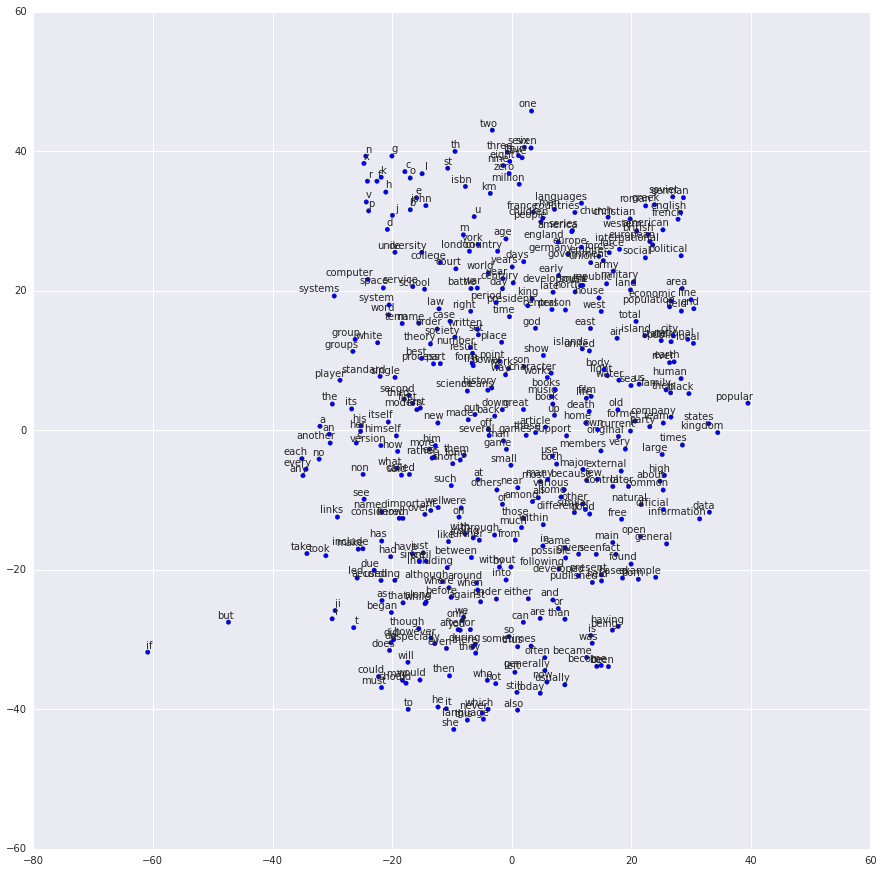

In [0]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

Much cleaner implementation than my first attempt, based on https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/5_word2vec.ipynb

Here each batch is a list of the surrounding words, and the label is the middle word.

```
data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_lookaround = 1 :
    reverse dictionary batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    reverse dictionary labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with bag_lookaround = 2 :
    reverse dictionary batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    reverse dictionary labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
```

In [5]:
data_index = 0

# num_words_in_bag excludes the center word.
def generate_batch_cbow(batch_size, bag_lookaround):
  global data_index
  num_words_in_bag = bag_lookaround * 2 # excludes the center word
  span = num_words_in_bag + 1 # includes the center word
  batch = np.ndarray(shape=(batch_size, num_words_in_bag), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    buffer_as_list = list(buffer)
    batch[i] = buffer_as_list[:bag_lookaround] + buffer_as_list[-bag_lookaround:]    
    labels[i, 0] = buffer[bag_lookaround]
#     print('batch[', i,']: ',batch[i])
    # During an append, data is kicked out from the left side because maxlen==span.
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:10]])

# bag_lookaround - number of words on either side to include in the window
for bag_lookaround in [1, 2]:
    data_index = 0
    print('\nwith bag_lookaround = %d :' % (bag_lookaround,))
    batch, labels = generate_batch_cbow(batch_size=8, bag_lookaround=bag_lookaround)    
    print('    reverse dictionary batch:', [[reverse_dictionary[x] for x in bi] for bi in batch])
    print('    reverse dictionary labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    batch:', batch)
    print('    labels:', labels)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with bag_lookaround = 1 :
    reverse dictionary batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    reverse dictionary labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    batch: [[5234   12]
 [3081    6]
 [  12  195]
 [   6    2]
 [ 195 3134]
 [   2   46]
 [3134   59]
 [  46  156]]
    labels: [[3081]
 [  12]
 [   6]
 [ 195]
 [   2]
 [3134]
 [  46]
 [  59]]

with bag_lookaround = 2 :
    reverse dictionary batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    reverse dictionary labels: ['as', 'a', 'term', 'of', 'abuse

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_lookaround = 2
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
print('valid_examples: ', valid_examples)
print('    as words: ', [reverse_dictionary[x] for x in valid_examples])
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_lookaround * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  print('embeddings.shape', embeddings.get_shape())
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  print('softmax_weights.get_shape()', softmax_weights.get_shape())
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  print('softmax_biases.get_shape(): ', softmax_biases.get_shape())
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # https://www.tensorflow.org/api_docs/python/tf/reduce_sum
  embed = tf.reduce_sum(embed, 1)
  print('embed.shape: ', embed.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

valid_examples:  [51 16 33 86 40 35  9 44  4  7 25 82 50 54 79 32]
    as words:  ['more', 'five', 'this', 'united', 'were', 'at', 'nine', 'their', 'one', 'to', 'on', 'states', 'all', 'been', 'about', 'be']
embeddings.shape (50000, 128)
softmax_weights.get_shape() (50000, 128)
softmax_biases.get_shape():  (50000,)
embed.shape:  (128, 128)


In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, bag_lookaround)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.729110
Nearest to more: vassalage, inks, unedited, quarto, ester, hicks, groundwater, metropolis,
Nearest to five: camps, arabians, flippers, outside, brentwood, popper, attract, schwa,
Nearest to this: deuce, vulnerability, frigate, att, seaway, nouveau, freemasons, travis,
Nearest to united: disulfide, groom, alvarado, widehat, creationism, habsburgs, tramp, russa,
Nearest to were: beeb, watercraft, slaying, inteligencia, pollard, conceiving, serge, kievan,
Nearest to at: aikido, effected, conquers, margraves, ayyavazhi, hmos, carrel, shutting,
Nearest to nine: eleanor, slavonic, hmso, avesta, gol, gkos, derrida, platoon,
Nearest to their: primitivism, med, africanus, exile, analyte, snowman, enclaves, freemasons,
Nearest to one: chapels, antioxidant, halakhic, andropov, cystic, subdue, chariots, oratio,
Nearest to to: tied, disastrously, minotaurs, suffix, specs, embodiment, death, adapters,
Nearest to on: sn, lipoproteins, snowfalls, improvisat

Average loss at step 52000: 3.096134
Average loss at step 54000: 3.089852
Average loss at step 56000: 2.924842
Average loss at step 58000: 3.021672
Average loss at step 60000: 3.053840
Nearest to more: less, rather, very, too, most, better, greater, larger,
Nearest to five: six, four, seven, eight, three, zero, two, nine,
Nearest to this: it, which, the, conditioners, every, a, what, another,
Nearest to united: confederate, uk, bosnia, abner, listings, ecclesiastes, involved, contraindicated,
Nearest to were: are, was, is, include, remain, have, including, morley,
Nearest to at: near, during, broadleaf, in, broccoli, inversely, determines, petrol,
Nearest to nine: eight, five, seven, six, four, zero, three, th,
Nearest to their: its, his, her, our, your, the, whose, my,
Nearest to one: stains, fridays, kauffman, chambre, four, caspar, squalor, percent,
Nearest to to: would, could, will, cannot, might, should, must, may,
Nearest to on: upon, irradiation, about, multihulls, bachchan, wit

In [8]:
num_points = 400

# Does not work without `method='exact'` because 
# of this bug https://github.com/scikit-learn/scikit-learn/issues/6665
# See also https://github.com/scikit-learn/scikit-learn/issues/6665#issuecomment-264087057
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [9]:
print(np.isfinite(final_embeddings).all()) # True

print(np.isnan(final_embeddings).any()) # False
print(np.isinf(final_embeddings).any()) # False

True
False
False


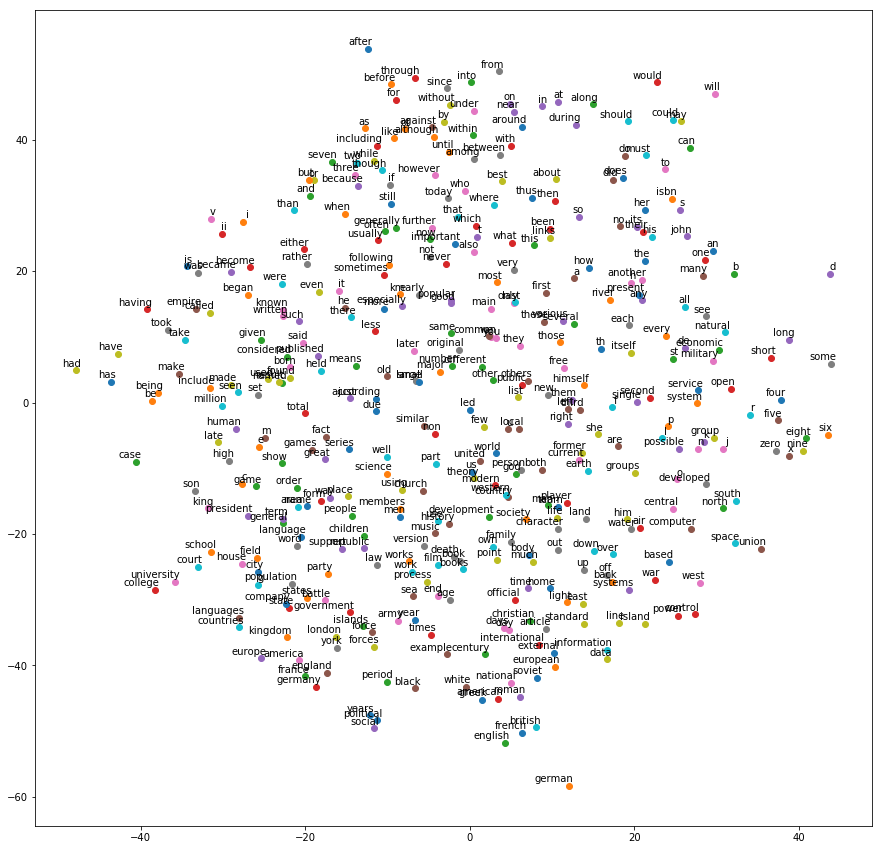

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)